In [1]:
import pandas as pd
import numpy as np
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
from sklearn.preprocessing import MinMaxScaler
import time
import warnings
warnings.simplefilter('ignore')
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()

# load data

In [2]:
tag = pd.read_csv('../data/tag_cleaned.csv',index_col=0)
tag_map = dict(zip(tag.TAG,tag.chinese))

In [3]:
df = pd.read_csv('../data/train_cleaned.csv',index_col=0,parse_dates=True)
print(df.shape)
df.sample(5)

(193824, 95)


,MLPAP_TJ-0706B02,MLPAP_TJ-0706B03,MLPAP_TJ-0706B04,MLPAP_TJ-0706B05,MLPAP_TJ-0706B06,MLPAP_TJ-0706B07,MLPAP_TJ-0706B08,MLPAP_TJ-0706B09,MLPAP_TJ-0706B10,MLPAP_TJ-0706B11,...,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TJC-0757.PV,MLPAP_V225-PHD,MLPAP_PI-0771.PV,MLPAP_TRC-0747.PV,Unnamed: 96,MLPAP_TRC-0497.PV
2016-07-30 10:20:00,387.0,410.09982,418.65027,427.00000,421.0,419.94836,415.00000,405.95172,392.96830,383.00000,...,16.648580,30.967512,NaN,486.49847,2.029989,0.039,138.000000,173.93372,NaN,8261.805
2016-09-20 01:00:00,381.0,401.00000,408.34283,416.09964,411.0,411.00000,410.00000,407.00000,395.00000,384.00000,...,18.108200,28.248755,NaN,423.63562,2.295043,0.043,114.891655,171.68623,NaN,8206.357
2019-03-07 23:20:00,380.0,395.09213,399.00000,403.00000,401.0,401.00494,401.00000,399.00000,398.00000,395.00000,...,14.338291,26.783918,6569.02,NaN,0.166344,0.014,130.612140,167.70000,NaN,8327.040
2017-02-16 13:00:00,376.0,393.15668,399.00000,405.00000,401.0,402.00000,403.05008,407.00000,403.17044,396.27087,...,16.362780,29.056238,NaN,420.12520,1.546241,0.024,107.794205,172.19420,NaN,7533.000
2017-06-28 14:10:00,375.0,392.35150,397.00000,403.00000,399.0,399.00000,399.00000,403.00000,403.00000,398.00000,...,15.244610,33.488810,NaN,NaN,2.620113,0.035,129.689380,173.70000,NaN,7533.000


# add total_stream

In [4]:
stream_cols = tag[tag.chinese.str.contains('蒸氣')== True].TAG.tolist()
print(stream_cols)
df['stream'] = df[stream_cols[0]]*1000 + df[stream_cols[1]]*1000
df['stream'].describe()

['MLPAP_FR-0755PV(轉換後)', 'MLPAP_FR-0791.PV', 'MLPAP_FI-V211.PV(轉換後)']


count    142409.000000
mean      44127.819436
std        5508.140284
min       12403.367700
25%       41163.371000
50%       45579.059000
75%       48093.826000
max       51416.351000
Name: stream, dtype: float64

# define columns

In [5]:
action = tag[tag['category']=='可控制因子']['TAG'].values.tolist()
action.remove('MLPAP_FQ-0619.PV')
action.remove('MLPAP_TJC-0757.PV')
action.remove('MLPAP_PIC-0741.PV')
action.insert(0,'MLPAP_FQ-0619.PV')

output = get_col(df,'0997')

stream = ['stream']

state = get_col(df,'DATA OF USE')

print('action:',action)
print()

print('output:',output)
print()

print('stream:',stream)
print()

print('state:',state)

action: ['MLPAP_FQ-0619.PV', 'MLPAP_TJC-0627.PV', 'MLPAP_TRC-0610.PV', 'MLPAP_FR-0632.PV', 'MLPAP_TJC-0757A.PV', 'MLPAP_LIC-0738.PV', 'MLPAP_PIC-0761.PV', 'MLPAP_TRC-0762.PV', 'MLPAP_LRC-0729.PV', 'MLPAP_TJC-1721.PV', 'MLPAP_TRC-1734.PV', 'MLPAP_TRC-0747.PV', 'MLPAP_TJ-0757B.PV']

output: ['MLPAP_FQI-0997.PV']

stream: ['stream']

state: ['DATA OF USE']


# select columns

In [6]:
df = df[state + action + output + stream]

# look miss value

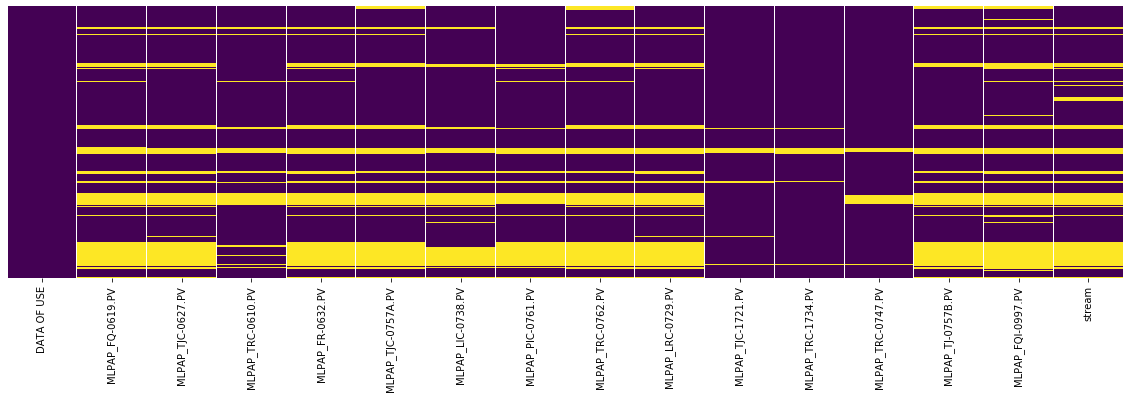

In [7]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# scale data

In [8]:
mm_state = MinMaxScaler()
mm_action = MinMaxScaler()
mm_output = MinMaxScaler()
mm_stream = MinMaxScaler()

df[state] = mm_state.fit_transform(df[state])
df[action] = mm_action.fit_transform(df[action])
df[output] = mm_output.fit_transform(df[output])
df[stream] = mm_stream.fit_transform(df[stream])

df.sample(5)

,DATA OF USE,MLPAP_FQ-0619.PV,MLPAP_TJC-0627.PV,MLPAP_TRC-0610.PV,MLPAP_FR-0632.PV,MLPAP_TJC-0757A.PV,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_TRC-0762.PV,MLPAP_LRC-0729.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_TRC-0747.PV,MLPAP_TJ-0757B.PV,MLPAP_FQI-0997.PV,stream
2017-12-25 18:50:00,0.442636,NaN,NaN,NaN,NaN,NaN,0.258888,0.643512,NaN,NaN,0.339051,0.487223,0.443110,NaN,NaN,NaN
2017-07-28 18:10:00,0.331173,0.951489,0.276235,0.634700,0.950260,0.082687,0.399397,0.935611,0.419509,0.390622,0.386135,0.453835,0.774046,0.128948,0.744004,0.924751
2019-04-12 23:40:00,0.794199,0.919336,0.720323,0.529087,0.896530,0.294387,0.826876,0.934616,0.564740,0.529752,0.380983,0.454903,0.706179,0.307928,0.651524,0.717689
2018-03-08 11:30:00,0.496644,0.964347,0.482416,0.529309,0.958685,0.233525,0.624506,0.926058,0.526278,0.422853,0.392159,0.432201,0.753955,0.245050,0.759339,0.924133
2019-10-23 01:40:00,0.937649,NaN,NaN,0.397501,NaN,NaN,NaN,NaN,NaN,NaN,0.345993,0.482543,0.364817,NaN,NaN,NaN


# build dataset for modeling

In [9]:
def build_dataset(df,n):
    
    data = {'state':[],
            'action':[],
            'output':[],
            'stream':[],
            'idx':[]}
    
    for i in tqdm(range(0,len(df)-n)):
        curr = df.iloc[i:i+n] #一小段資料
        if np.isnan(curr.values).sum() == 0: #確保這段資料無缺失值
            
            data['state'].append(curr[state].values.mean())#這段時間的觸媒使用時間 均值
            data['action'].append(curr[action].values)# 這段時間 "所有" 操作
            data['output'].append(curr[output].values[-1])#這段時間 最後一個時間點 的出料
            data['stream'].append(curr[stream].median())#這段時間蒸氣的 中位數
            data['idx'].append(curr.index[-1]) #這段時間最後 出料對應的時間點
    
    # reshape
    data['state'] = np.array(data['state']).reshape(-1,1)
    data['action'] = np.array(data['action'])
    data['output'] = np.array(data['output']).reshape(-1,1)
    data['stream'] = np.array(data['stream']).reshape(-1,1)
    
    # store scaler
    data['mm_state'] = mm_state
    data['mm_action'] = mm_action
    data['mm_output'] = mm_output
    data['mm_stream'] = mm_stream
    
    # store col_name
    data['state_col'] = state
    data['action_col'] = action
    data['output_col'] = output
    data['stream_col'] = stream
    
    return data

In [10]:
data = build_dataset(df,36)

In [11]:
print(len(data['idx']))

130823


# save

In [12]:
joblib.dump(data,'../data/dataset.pkl')

['../data/dataset.pkl']